In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import torch.nn as nn
from diffusers.utils import BaseOutput
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import (
    DiffusionPipeline,
    DDIMScheduler,
    DDPMScheduler,
    UNet2DConditionModel,
    AutoencoderKL,
)
num_train_timesteps=999
unet = UNet2DConditionModel(
).from_pretrained('./stable-diffusion-v1-5',
                  subfolder="unet",
                  in_channels=8,
                  out_channels=4,
                  low_cpu_mem_usage=False,
                  ignore_mismatched_sizes=True,
                  local_files_only = True)
vae = AutoencoderKL().from_pretrained('./stable-diffusion-v1-5',subfolder="vae")
scheduler = DDIMScheduler(num_train_timesteps=1000).from_pretrained('./stable-diffusion-v1-5',subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained('./stable-diffusion-v1-5',subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained('./stable-diffusion-v1-5',subfolder="text_encoder")

device = 'cuda'
vae.requires_grad_(False)
unet.requires_grad_(True)
text_encoder.requires_grad_(False)
text_encoder.text_model.embeddings.token_embedding.requires_grad_(False)

vae.eval()
unet.train()
text_encoder.eval()
# text_encoder.text_model.embeddings.token_embedding.eval()

vae.to(device)
unet.to(device)
text_encoder.to(device)

/home/boom/anaconda3/envs/marigold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of UNet2DConditionModel were not initialized from the model checkpoint at ./stable-diffusion-v1-5 and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 8, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [2]:
rgb_latent_scale_factor = 0.18215
def encode_3c(render: torch.Tensor) -> torch.Tensor:
        # encode
        h = vae.encoder(render)
        moments = vae.quant_conv(h)
        mean, logvar = torch.chunk(moments, 2, dim=1)
        # scale latent
        render_latent = mean * rgb_latent_scale_factor
        return render_latent
def normalize(data_tensor):
    min_val = data_tensor.min()
    max_val = data_tensor.max()
    return (data_tensor - min_val) / (max_val - min_val)

In [3]:
data_label = np.load('./fringe_label_alld.npy').transpose((0,3,1,2))
data  = data_label[:,0:3,:,:]
label = data_label[:,3:6,:,:]
print(data.shape,label.shape)
print(data.max(),data.min())
print(label.max(),label.min())
# data  = normalize(data)
data = (data + 1)/2
label = normalize(label)
print(data.shape,label.shape)
print(data.max(),data.min())
print(label.max(),label.min())

data_label = np.concatenate([data,label],axis=1)
print(data_label.shape)
data_label = torch.from_numpy(data_label) #.to(device)

(612, 3, 480, 640) (612, 3, 480, 640)
1.0 -1.0
285.05185 22.0
(612, 3, 480, 640) (612, 3, 480, 640)
1.0 0.0
1.0 0.0
(612, 6, 480, 640)


In [4]:
loader = torch.utils.data.DataLoader(
    dataset=data_label,
    batch_size=1,
    shuffle=True,
    drop_last=True,
)
len(loader), next(iter(loader)).shape

(612, torch.Size([1, 6, 480, 640]))

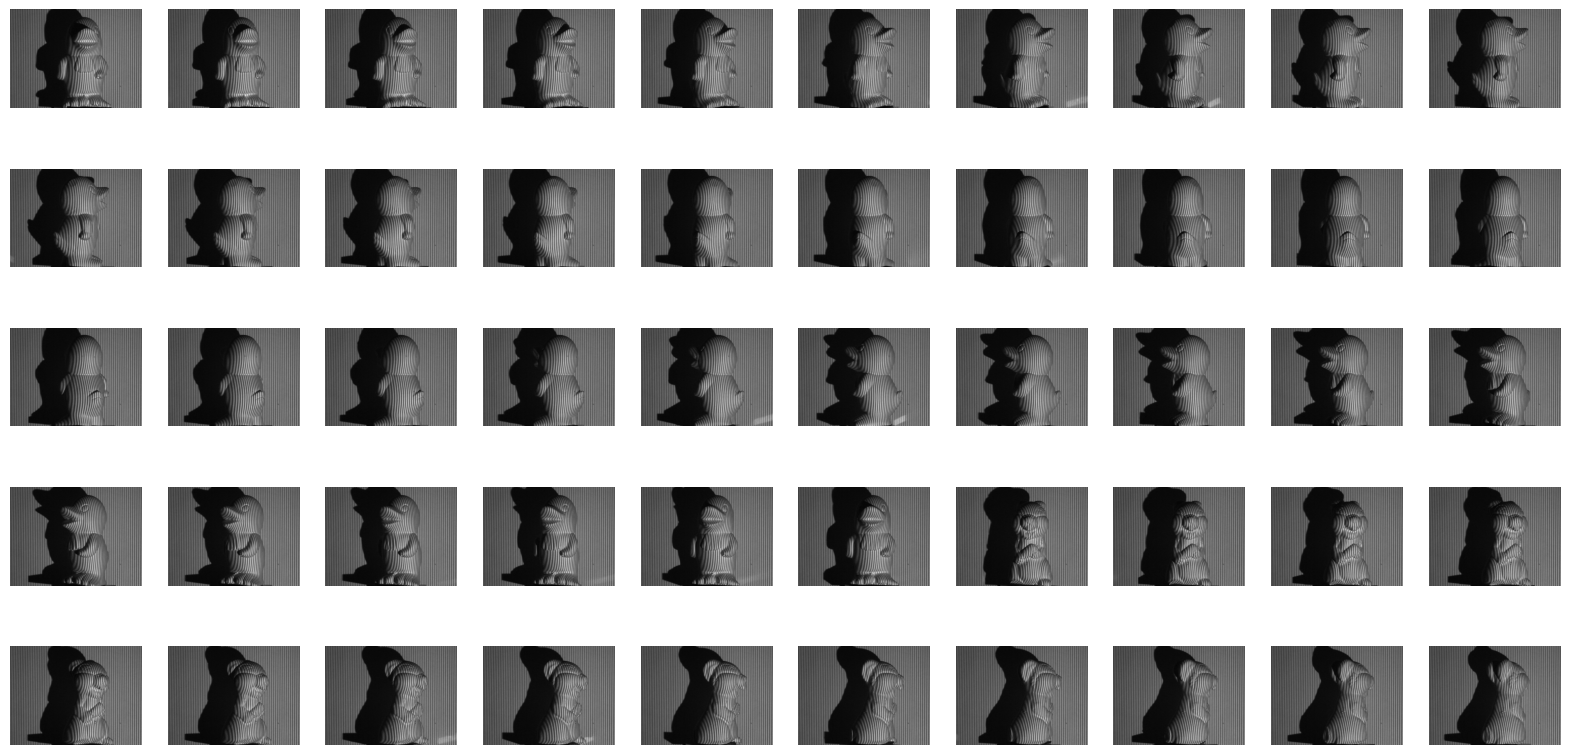

In [5]:
def show(images,save=False,name='default'):
    from matplotlib import pyplot as plt
    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()
    images = images[:50]
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        # image = (image + 1) / 2
        if image.shape[2] == 1:
            plt.subplot(5, 10, i + 1)
            plt.imshow(image,cmap='gray')
            plt.axis('off')   
        else:
            plt.subplot(5, 10, i + 1)
            plt.imshow(image)
            plt.axis('off')
    if save:
        plt.savefig(f'{name}.pdf',dpi=600) 
    plt.show()
def show_error_map(pred, gd, save=False,name='default'):
    # Ensure the tensors have the same shape
    assert pred.shape == gd.shape, "Input tensors must have the same shape"
    pred = pred.mean(dim=1, keepdim=True)
    gd = gd.mean(dim=1, keepdim=True)
    # Calculate the absolute difference between the prediction and ground truth
    error_map = torch.abs(pred - gd) * 10
    show(error_map,save,name)
show(data_label[:,0:3,:,:],save=True)

In [6]:
# print(data[:,0:3,:,:].max(), data[:,0:3,:,:].min())
# print(data[:,4:5,:,:].max(), data[:,4:5,:,:].min())
# data = normalize(data)
# print(data[:,0:3,:,:].max(), data[:,0:3,:,:].min())
# print(data[:,4:5,:,:].max(), data[:,4:5,:,:].min())

In [7]:
class FinetuneUnet(nn.Module):
    rgb_latent_scale_factor = 0.18215
    depth_latent_scale_factor = 0.18215
    def __init__(
            self,
            unet: unet,
            vae: AutoencoderKL,
            scheduler: DDIMScheduler,
            text_encoder: CLIPTextModel,
            tokenizer: CLIPTokenizer,
    ):
        super(FinetuneUnet, self).__init__()
        self.unet = unet
        self.vae = vae
        self.scheduler = scheduler
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.empty_text_embed = None

    def __encode_empty_text(self):
        """
        Encode text embedding for empty prompt
        """
        prompt = ""
        text_inputs = self.tokenizer(
            "",
            padding="do_not_pad",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids.to(self.text_encoder.device)
        self.empty_text_embed = self.text_encoder(text_input_ids)[0].to(torch.float32)

    def encode_3c(self, render: torch.Tensor) -> torch.Tensor:
        # encode
        h = self.vae.encoder(render)
        moments = self.vae.quant_conv(h)
        mean, logvar = torch.chunk(moments, 2, dim=1)
        # scale latent
        render_latent = mean * self.rgb_latent_scale_factor
        return render_latent

    def forward(self,data_label):
        device = data_label.device
        data  = data_label[:,0:3,:,:]
        label = data_label[:,3:6,:,:]
        data_latent  = encode_3c(data) # 1,4,60,80
        depth_latent = encode_3c(label) # 1,4,60,80
        
        # noise is 4 channel
        noise = torch.randn((data_latent.shape[0],4,data_latent.shape[2],data_latent.shape[3]), device=device) # noise for depth_latent
        bs = data_latent.shape[0]
        timesteps = torch.randint(
            0, self.scheduler.config.num_train_timesteps, (bs,), device=device,
            dtype=torch.int64
        )
        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_depth_latent = self.scheduler.add_noise(depth_latent, noise, timesteps)

        # empty text embedding
        if self.empty_text_embed is None:
            self.__encode_empty_text()
        batch_empty_text_embed = self.empty_text_embed.repeat(
            (data_latent.shape[0], 1, 1)
        )  # [B, 2, 1024]

        unet_input = torch.cat([data_latent,noisy_depth_latent],dim=1)
        pred_noise = self.unet(unet_input,timesteps,encoder_hidden_states=batch_empty_text_embed).sample
        return pred_noise, noise

In [8]:
from skimage.metrics import structural_similarity as ssim
def ssim_loss(data,pred):
    ssim_values = 0.0  # Initialize a variable to accumulate SSIM values
    # Loop through the batch of images
    data = data.detach().cpu().numpy().transpose(0, 2, 3, 1)
    pred = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
    for i in range(data.shape[0]):
        # Calculate SSIM between original and reconstructed image
        # ssim_val = ssim(upscaled_img1, upscaled_img2, multichannel=True, channel_axis=2)
        ssim_val = ssim(data[i], pred[i], multichannel=True, data_range=data[i].max()-data[i].min())
        ssim_values += ssim_val
    # Compute the average SSIM across all images in the batch
    average_ssim = ssim_values / data.shape[0]
    loss = 1 - average_ssim
    return loss

In [9]:
device = "cuda"
model = FinetuneUnet(unet=unet, vae=vae, scheduler=scheduler, text_encoder=text_encoder, tokenizer=tokenizer)
model = model.to(device)

In [10]:
from skimage.metrics import structural_similarity as ssim
log_file_path = "train_log.txt"
log_file = open(log_file_path, "a")  # Open the log file in append mode
def train():
    criterion1 = torch.nn.L1Loss()
    criterion2 = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=1e-5,                   
                                  weight_decay=1e-4)
    model.to(device)
    model.train()

    loss_sum = 0
    for epoch in range(400):
        for i, data in enumerate(loader):
            # print(data.shape)
            pred_noise, noise = model(data.to(device)) 
            # print(pred_noise.shape, noise.shape)
            loss = criterion2(pred_noise, noise)/4
            # loss = loss + 1 * ssim_loss(pred_noise, noise)
            loss.backward()
            loss_sum += loss.item()
            if (epoch * len(loader) + i) % 4 == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()
                log_file.write(f"Epoch {epoch + 1}, Batch {i + 1}/{len(loader)}, Loss: {loss.item():.4f}\n")
                log_file.flush()  # Flush the buffer to ensure immediate writing
                print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(loader)}, Loss: {loss.item():.4f}", end='\r')
        if epoch % 1 == 0:
            print(epoch, loss_sum)
            loss_sum = 0  
        torch.save(model.state_dict(), './all_in_one_unet_finetune_sl.pth')
train()

In [ ]:
# def train():
#     loss_sum = 0
#     for epoch in range(400):
#         for i, data in enumerate(loader):
#             loss = get_loss(data) / 4
#             loss.backward()
#             loss_sum += loss.item()

#             if (epoch * len(loader) + i) % 4 == 0:
#                 torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
#                 optimizer.step()
#                 optimizer.zero_grad()

#         if epoch % 10 == 0:
#             print(epoch, loss_sum)
#             loss_sum = 0

#     #torch.save(unet.to('cpu'), 'saves/unet.model')


# train()